In [1]:
import numpy as np
import json
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchattacks import *

from utils import *

from tqdm import tqdm
# from utils import imshow, image_folder_custom_label

In [2]:
Batch_size = 100
thr = 10000
attack = "FGSM"
model_name = "resnet18"

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
val_dataset = torchvision.datasets.ImageNet(root="./dataset", split='val',transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=5)

# load model

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [6]:
norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [18]:
pretrained_models = {
    "resnet18":models.resnet18(pretrained=True),
    "alexNet":models.alexnet(pretrained=True),
    "vgg11":models.vgg11(pretrained=True),
    "mobilenet":models.mobilenet_v3_large(pretrained = True),
    "shufflenet":models.shufflenetv2(pretrained=True)
    }


pretrained_model = pretrained_models[model_name]

model = nn.Sequential(
    norm_layer,
    pretrained_model
).to(device)
model = model.eval()

In [8]:
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
train_dataset = torchvision.datasets.ImageNet(root="./dataset", split='train',transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=5)

In [9]:
atks = {"FGSM" : FGSM(model, eps=8/255),
        "BIM" : BIM(model, eps=8/255, alpha=2/255, steps=100),
        "RFGSM" :  RFGSM(model, eps=8/255, alpha=2/255, steps=100),
        "CW"    :CW(model, c=1, lr=0.01, steps=100, kappa=0),
        "PGD" :   PGD(model, eps=8/255, alpha=2/225, steps=100, random_start=True),
        "PGDL2":   PGDL2(model, eps=1, alpha=0.2, steps=100),
        "EOTPGD":   EOTPGD(model, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
        "FFGSM" :  FFGSM(model, eps=8/255, alpha=10/255),
        "TPGD" :   TPGD(model, eps=8/255, alpha=2/255, steps=100),
        "MIFGSM" : MIFGSM(model, eps=8/255, alpha=2/255, steps=100, decay=0.1),
        "VANILA" : VANILA(model),
        "GN" : GN(model, std=0.1),
        "APGD_ce" :APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
        "APGD_dlr" : APGD(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
        "APGDT":APGDT(model, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
        "FAB":  FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
        "FAB_target": FAB(model, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
        "SQUARE": Square(model, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
        "AUTOATTACK": AutoAttack(model, eps=8/255, n_classes=10, version='standard'),
        "OnePixel": OnePixel(model, pixels=5, inf_batch=50),
        "DEEPFOOL": DeepFool(model, steps=100),
        "DIFGSM":DIFGSM(model, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
    }

atk = atks[attack]

In [10]:
idx = 0
Y_sen_list = np.empty([0, 8, 8])
Cb_sen_list = np.empty([0, 8, 8])
Cr_sen_list = np.empty([0, 8, 8])

for images, labels in tqdm(train_loader):
    img_shape = images.shape[-2:]
    images, labels = images.to(device), labels.to(device)
    # generate adv images
    # adv_images = atk(images, labels)
    adv_images = images
    # DCT 
    ycbcr_adv_images = rgb_to_ycbcr(adv_images)
    input_adv_DCT_block_batch = block_dct(blockify(ycbcr_adv_images, 8))
    input_adv_DCT_block_batch.requires_grad = True
    recoverd_adv_img = deblockify(block_idct(input_adv_DCT_block_batch), (img_shape[0], img_shape[1]))
    # feed the attack to DNN
    outputs = model(ycbcr_to_rgb(recoverd_adv_img))
    _, pre = torch.max(outputs.data, 1)
    loss = torch.nn.CrossEntropyLoss()(outputs, pre)
    model.zero_grad()
    loss.backward()
    data_grad = torch.mean(torch.abs(input_adv_DCT_block_batch.grad), dim = 2).transpose(1,0).detach().cpu().numpy()
    Y_sen_list = np.concatenate((Y_sen_list, data_grad[0].reshape(-1, 8, 8)))
    Cb_sen_list = np.concatenate((Cb_sen_list, data_grad[1].reshape(-1, 8, 8)))
    Cr_sen_list = np.concatenate((Cr_sen_list, data_grad[2].reshape(-1, 8, 8)))
    idx += Batch_size
    if idx >= thr:
        break

  0%|          | 99/128117 [00:11<4:11:56,  8.47it/s]


In [11]:
[Y_b,Y_m,Y_u] = plot_save_senmap(Y_sen_list, "Y", "Resnet18")
[Cb_b,Cb_m,Cb_u] = plot_save_senmap(Cb_sen_list, "Cb", "Resnet18")
[Cr_b,Cr_m,Cr_u] = plot_save_senmap(Cr_sen_list, "Cr", "Resnet18")

100%|██████████| 64/64 [00:00<00:00, 280.18it/s]


In [12]:
idx = 0
Y_sen_list = np.empty([0, 8, 8])
Cb_sen_list = np.empty([0, 8, 8])
Cr_sen_list = np.empty([0, 8, 8])

for images, labels in tqdm(train_loader):
    img_shape = images.shape[-2:]
    images, labels = images.to(device), labels.to(device)
    # generate adv images
    adv_images = atk(images, labels)
    # adv_images = images
    # DCT 
    ycbcr_adv_images = rgb_to_ycbcr(adv_images)
    input_adv_DCT_block_batch = block_dct(blockify(ycbcr_adv_images, 8))
    input_adv_DCT_block_batch.requires_grad = True
    recoverd_adv_img = deblockify(block_idct(input_adv_DCT_block_batch), (img_shape[0], img_shape[1]))
    # feed the attack to DNN
    outputs = model(ycbcr_to_rgb(recoverd_adv_img))
    _, pre = torch.max(outputs.data, 1)
    loss = torch.nn.CrossEntropyLoss()(outputs, pre)
    model.zero_grad()
    loss.backward()
    data_grad = torch.mean(torch.abs(input_adv_DCT_block_batch.grad), dim = 2).transpose(1,0).detach().cpu().numpy()
    Y_sen_list = np.concatenate((Y_sen_list, data_grad[0].reshape(-1, 8, 8)))
    Cb_sen_list = np.concatenate((Cb_sen_list, data_grad[1].reshape(-1, 8, 8)))
    Cr_sen_list = np.concatenate((Cr_sen_list, data_grad[2].reshape(-1, 8, 8)))
    idx += Batch_size
    if idx >= thr:
        break

  0%|          | 99/128117 [00:19<7:08:11,  4.98it/s]


In [13]:
[Y_adv_b,Y_adv_m,Y_adv_u] = plot_save_senmap(Y_sen_list, "Y_adv", "Resnet18")
[Cb_adv_b,Cb_adv_m,Cb_adv_u] = plot_save_senmap(Cb_sen_list, "Cb_adv", "Resnet18")
[Cr_adv_b,Cr_adv_m,Cr_adv_u] = plot_save_senmap(Cr_sen_list, "Cr_adv", "Resnet18")

100%|██████████| 64/64 [00:00<00:00, 271.15it/s]


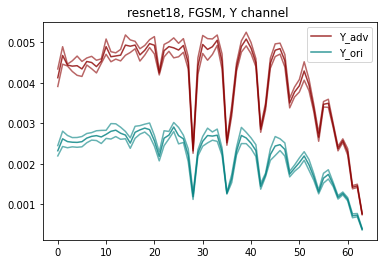

In [14]:
plt.plot(Y_adv_b,c='darkred',alpha = 0.6)
plt.plot(Y_adv_m, label="Y_adv",c='darkred',alpha = 0.8)
plt.plot(Y_adv_u,c='darkred',alpha = 0.6)
plt.plot(Y_b, c='teal', alpha = 0.6)
plt.plot(Y_m, label="Y_ori", c='teal', alpha = 0.8)
plt.plot(Y_u, c='teal', alpha = 0.6)
plt.title(model_name+", "+attack+", "+"Y channel ")
plt.savefig(model_name+"_"+attack+"_"+"Y_channel ")
plt.legend()

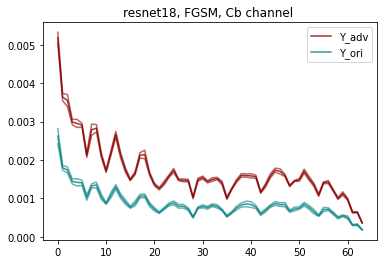

In [15]:
plt.plot(Cb_adv_b,c='darkred',alpha = 0.6)
plt.plot(Cb_adv_m, label="Y_adv",c='darkred',alpha = 0.8)
plt.plot(Cb_adv_u,c='darkred',alpha = 0.6)

plt.plot(Cb_b,alpha = 0.6, c='teal')
plt.plot(Cb_m, label="Y_ori", c='teal', alpha = 0.8)
plt.plot(Cb_u, c='teal', alpha = 0.6)
plt.title(model_name+", "+attack+", "+"Cb channel ")
plt.savefig(model_name+"_"+attack+"_"+"Cb_channel.pdf")
plt.legend()

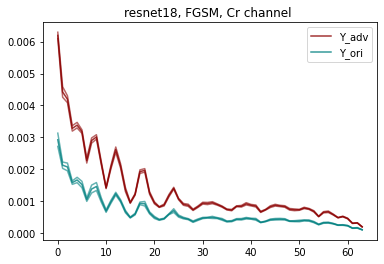

In [16]:
plt.plot(Cr_adv_b,c='darkred',alpha = 0.6)
plt.plot(Cr_adv_m, label="Y_adv",c='darkred',alpha = 0.8)
plt.plot(Cr_adv_u,c='darkred',alpha = 0.6)
plt.plot(Cr_b,alpha = 0.6, c='teal')
plt.plot(Cr_m, label="Y_ori", c='teal', alpha = 0.8)
plt.plot(Cr_u, c='teal', alpha = 0.6)
plt.title(model_name+", "+attack+", "+"Cr channel ")
plt.savefig(model_name+"_"+attack+"_"+"Cr_channel.pdf")
plt.legend()